In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Regresión Logística

Algoritmo de CLASIFICACIÓN, que tradicionalmente es binario

In [3]:
df = pd.read_csv("../data/2008_small.zip",nrows=100000)
df = df[["AirTime","Distance","TaxiOut","ArrDelay","DepDelay"]].dropna()

X = df[df.columns[df.columns != "ArrDelay"]]
filtro = df["ArrDelay"] > 10 
df["ArrDelay"][filtro] = "Delayed"
df["ArrDelay"][filtro== False] = "Not Delayed"
Y = df["ArrDelay"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

In [4]:
clf = LogisticRegression(penalty = "none").fit(X_train, y_train)
predicciones = clf.predict(X_test)
predicciones

array(['Not Delayed', 'Delayed', 'Not Delayed', ..., 'Not Delayed',
       'Not Delayed', 'Not Delayed'], dtype=object)

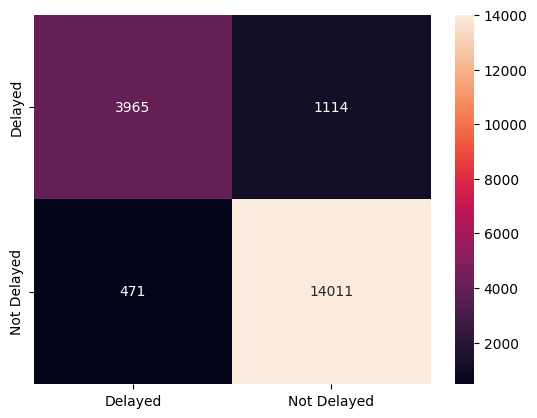

In [5]:
confusion = confusion_matrix(y_test,predicciones)
ax = sns.heatmap( confusion, annot=True,fmt='.6g',
            xticklabels= clf.classes_, 
            yticklabels=clf.classes_)

# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [6]:
y_test.value_counts() / len(y_test)

Not Delayed   0.740
Delayed       0.260
Name: ArrDelay, dtype: float64

In [7]:
np.mean(predicciones == y_test)

0.9189714227288993

### F1 Score 
En modelos de clasificación una métrica común para evaluar la calidad del modelo es la puntuación F1.

El score F1 se define como la **media armónica de precisión y exhaustividad**.

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)



In [8]:
f1_score(y_test, predicciones, average='macro')

0.8899431386333503

In [9]:
clf.classes_

array(['Delayed', 'Not Delayed'], dtype=object)

In [10]:
predicciones

array(['Not Delayed', 'Delayed', 'Not Delayed', ..., 'Not Delayed',
       'Not Delayed', 'Not Delayed'], dtype=object)

In [11]:
clf.predict_proba(X_test).round(4)

array([[0.0023, 0.9977],
       [1.    , 0.    ],
       [0.    , 1.    ],
       ...,
       [0.0214, 0.9786],
       [0.1613, 0.8387],
       [0.2137, 0.7863]])

In [12]:
prob_delayed = clf.predict_proba(X_test)[:,0]

delayedseguras = prob_delayed > 0.6
notdelayedseguras = prob_delayed < 0.4
torevise = (prob_delayed >= 0.4) & (prob_delayed <= 0.6)

In [13]:
X_test[delayedseguras]

,AirTime,Distance,TaxiOut,DepDelay
46242,137.000,1062,14.000,84.000
57991,106.000,694,13.000,46.000
36435,63.000,526,50.000,123.000
26472,33.000,153,22.000,85.000
3411,169.000,802,14.000,-4.000
...,...,...,...,...
62902,93.000,644,9.000,90.000
4797,203.000,1372,22.000,110.000
47573,107.000,802,20.000,34.000
22807,65.000,413,28.000,10.000


# Árbol de Regresión

In [14]:
df = pd.read_csv("../data/2008_small.zip",index_col = 0, nrows = 200000)

In [15]:
df = df.dropna(subset = ["ArrDelay"])
df = df[df.AirTime > 0]

X = df[['AirTime','Distance','TaxiIn','TaxiOut', 'DepDelay']]
Y = df[["ArrDelay"]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

arbol = tree.DecisionTreeRegressor()
arbol = arbol.fit(X_train, y_train)

prediccionesINTERNA = arbol.predict(X_train)
print("R2 INTERNA: ",r2_score(y_train, prediccionesINTERNA))

prediccionesEXTERNA = arbol.predict(X_test)
print("R2 EXTERNA: ",r2_score(y_test, prediccionesEXTERNA))

R2 INTERNA:  0.9999627244847715
R2 EXTERNA:  0.8831018473857203


>Ajuste de parámetros (ensayo y error)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2)

In [18]:
arbol = tree.DecisionTreeRegressor(max_depth=10)
arbol = arbol.fit(X_train, y_train)

prediccionesINTERNA = arbol.predict(X_train)
print("R2 INTERNA: ",r2_score(y_train, prediccionesINTERNA))

prediccionesEXTERNA = arbol.predict(X_test)
print("R2 EXTERNA: ",r2_score(y_test, prediccionesEXTERNA))

R2 INTERNA:  0.9335996549350403
R2 EXTERNA:  0.919921204048641


### Ensayo de parámetros (más automatizado)

Estructura de guardado de datos (basada en una función de R, llamada expand.grid)

In [19]:
from itertools import product

# Esta función no hace falta entenderla en detalle :)
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

parametros = {'semillas': range(0,15), # Vamos a hacer 10 conjuntos distintos de train/test
              'profundidades': range(3,25,1), #Vamos a probar profundidades 1, 4, 7..
              'splitter': ["best", "random"], #Y vamos a seleccionar la variable de cada partición de manera óptima / aleatoria
              'R2': [np.nan]}

dfparam = expand_grid(parametros) # Crea un dataframe con todas las combinaciones de parámetros
dfparam.head(10)

,semillas,profundidades,splitter,R2
0,0,3,best,NaN
1,0,3,random,NaN
2,0,4,best,NaN
3,0,4,random,NaN
4,0,5,best,NaN
5,0,5,random,NaN
6,0,6,best,NaN
7,0,6,random,NaN
8,0,7,best,NaN
9,0,7,random,NaN


In [20]:
for semilla in tqdm(parametros["semillas"]):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=semilla)
    for prof in parametros["profundidades"]:
        for split in parametros["splitter"]:
  
            arbol = tree.DecisionTreeRegressor(max_depth=prof, splitter=split)
            arbol = arbol.fit(X_train, y_train)

            prediccionesEXTERNA = arbol.predict(X_test)
            dfparam.loc[(dfparam.semillas == semilla) & (dfparam.profundidades == prof) & (dfparam.splitter == split),"R2"] = r2_score(y_test, prediccionesEXTERNA)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [07:04<00:00, 28.27s/it]


In [ ]:
for i in tqdm(range(dfparam.shape[0])):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        random_state=dfparam.loc[i,"semillas"])
    
    arbol = tree.DecisionTreeRegressor(max_depth=dfparam.loc[i,"profundidades"], 
                                       splitter=dfparam.loc[i,"splitter"])
    arbol = arbol.fit(X_train, y_train)

    prediccionesEXTERNA = arbol.predict(X_test)
    dfparam.loc[i,"R2"] = r2_score(y_test, prediccionesEXTERNA)


In [21]:
dfparam.sort_values("R2",ascending=False)

,semillas,profundidades,splitter,R2
366,8,10,best,0.929
14,0,10,best,0.928
16,0,11,best,0.928
324,7,11,best,0.928
12,0,9,best,0.928
...,...,...,...,...
441,10,3,random,0.184
575,13,4,random,0.173
403,9,6,random,0.158
1,0,3,random,0.156


In [22]:
dfparam.groupby("profundidades").mean()["R2"]

profundidades
3    0.638
4    0.706
5    0.793
6    0.784
7    0.864
8    0.887
9    0.892
10   0.904
11   0.914
12   0.917
13   0.918
14   0.918
15   0.917
16   0.919
17   0.917
18   0.916
19   0.914
20   0.911
21   0.909
22   0.906
23   0.904
24   0.901
Name: R2, dtype: float64

In [23]:
dfparam.groupby("splitter").mean()["R2"].sort_values(ascending=False)

splitter
best     0.908
random   0.842
Name: R2, dtype: float64

In [24]:
dfparam.groupby("semillas").mean()["R2"].sort_values(ascending=False)

semillas
3    0.891
14   0.888
12   0.887
11   0.886
4    0.885
5    0.883
7    0.883
8    0.880
6    0.877
1    0.874
13   0.869
0    0.864
10   0.858
2    0.854
9    0.847
Name: R2, dtype: float64

In [25]:
dfparam.groupby(["profundidades","splitter"]).mean()["R2"]

profundidades  splitter
3              best       0.827
               random     0.450
4              best       0.874
               random     0.538
5              best       0.899
               random     0.688
6              best       0.910
               random     0.659
7              best       0.916
               random     0.812
8              best       0.920
               random     0.854
9              best       0.922
               random     0.861
10             best       0.923
               random     0.885
11             best       0.923
               random     0.904
12             best       0.923
               random     0.911
13             best       0.922
               random     0.915
14             best       0.921
               random     0.916
15             best       0.920
               random     0.915
16             best       0.918
               random     0.920
17             best       0.916
               random     0.918
18             b

In [26]:
dfparam.sort_values("R2",ascending=False).head(20)

,semillas,profundidades,splitter,R2
366,8,10,best,0.929
14,0,10,best,0.928
16,0,11,best,0.928
324,7,11,best,0.928
12,0,9,best,0.928
364,8,9,best,0.928
322,7,10,best,0.928
326,7,12,best,0.928
368,8,11,best,0.928
18,0,12,best,0.928


In [27]:
dfparam.sort_values("R2",ascending=False).tail(20)

,semillas,profundidades,splitter,R2
177,4,3,random,0.499
133,3,3,random,0.492
353,8,3,random,0.485
271,6,6,random,0.465
397,9,3,random,0.447
445,10,5,random,0.383
399,9,4,random,0.376
405,9,7,random,0.372
447,10,6,random,0.339
577,13,5,random,0.287


# Ejercicios

In [ ]:
# https://github.com/mwaskom/seaborn-data
car_data=sns.load_dataset("mpg")
car_data

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from itertools import product
df = car_data.dropna()
df = df.reset_index() #Evitamos que aparezcan índices sin datos en el dataframe

# Importación de una función personalizada que permite conseguir un dataframe con todas las combinaciones de parámetros (requiere un diccionario)
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

#Dummies
df["cylinders_cat"] = df["cylinders"].astype("str") # Conversión a string de las variables numéricas que queremos convertir a dummies
df["model_year_cat"] = df["model_year"].astype("str")
df["interaccion"] =  df["model_year_cat"] + " " + df["cylinders_cat"] # Interacción entre variables categóricas
dummies = pd.get_dummies(df[["origin","interaccion"]]) # Conversión a dummies de las variables categóricas

Y = df[["mpg"]] # Selección de la variable respuesta
X = df[["displacement","horsepower","weight","acceleration","model_year","cylinders"]] #Selección de las variables numéricas explicativas

# Escalado
transformados = preprocessing.scale(X) # Escalado de datos (no se guardan)
#X = pd.DataFrame(transformados, columns = X.columns) # Descomentar si queremos escalar datos numéricos

# Polinomios
poly = PolynomialFeatures(interaction_only=True) # Creo las interacciones entre variables numéricas
X_poly = poly.fit_transform(X) # Creo la variable con las interacciones
X = pd.DataFrame(X_poly, columns = poly.get_feature_names(X.columns)) #Sobreescribo X
X = pd.concat([X,dummies],axis = 1) # Descomentar si queremos añadir dummies

#Creamos el dataframe con las combinaciones de parámetros y semillas que queremos probar
parametros = {'semillas': range(0,20),'profundidades': range(2,30,1),'splitter': ["best", "random"],'R2': [np.nan]}
dfparam = expand_grid(parametros) 

# Entrenamos y evaluamos todas las combinaciones! (bucle por filas del dataframe de parámetros)
for i in tqdm(range(dfparam.shape[0])):
    #Creamos el conjunto train test con la semilla correspondiente
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        random_state=dfparam.loc[i,"semillas"])
    
    # Creamos el árbol con los parámetros que le corresponden
    arbol = tree.DecisionTreeRegressor(max_depth=dfparam.loc[i,"profundidades"], 
                                       splitter=dfparam.loc[i,"splitter"],random_state=1)
    arbol = arbol.fit(X_train, y_train) # Ajustamos el árbol con los datos

    prediccionesEXTERNA = arbol.predict(X_test) # Hacemos las predicciones con los datos que el modelo aún no ha visto
    dfparam.loc[i,"R2"] = r2_score(y_test, prediccionesEXTERNA) # Añadimos al dataframe los resultados del R2 externo

# Mostramos las mejores combinaciones de parámetros y semilla
resultados = dfparam.groupby(["profundidades","splitter"]).mean().sort_values("R2",ascending = False)["R2"]
resultados

In [ ]:
resultados.index[0]

In [ ]:
resultados.index[0]

arbol = tree.DecisionTreeRegressor(max_depth=resultados.index[0][0], 
                                   splitter=resultados.index[0][1],
                                   random_state=1)
arbol = arbol.fit(X, Y)

1. Estudia el dataframe, se llama mpg, puedes buscar qué significan exactamente las variables, y hacer una descripción (numérica y gráfica) de las que te parezcan más relevantes

2. Ajusta un modelo predictivo sencillo para el el consumo del coche (mpg). Evalúa su potencial predictivo tanto interna como externamente

3. Ajusta algunos de los parámetros que conocemos (o alguno nuevo) para intentar mejorar las predicciones

4. Ajusta los parámetros que creas convenientes (o explora algunos nuevos), intenta replicar una estructura de tipo bucle para hacerlo, mostrando los mejores resultados que hayas encontrado

### Clasificación 

1. Ajusta un modelo predictivo para el origen de los coches, o categoriza una variable como el consumo o el peso de los coches

2. Evalúa el modelo predictivo de varias formas

3. Ajusta los parámetros que creas convenientes, intenta replicar una estructura de tipo bucle para hacerlo, mostrando los mejores resultados que hayas encontrado

4. Compara distintos modelos de clasificación, cuál funciona mejor?